### Summary 

1. Load and explore data
2. Clean and preprocess text
3. Feature engineering (length, punctuation)
4. Vectorize text (TF-IDF, Word2Vec)
5. Build and evaluate models
6. Visualize results
7. Predict new reviews

In [61]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
import re 
import string
import gensim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nirma\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

## Data Loading and Understanding

In [11]:
data = pd.read_csv("IMDBDataset.csv")[:5000]

In [12]:
data.columns = ['review_body_text', 'sentiment']

In [13]:
data.head()

,review_body_text,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#Handling null values
data.isnull().sum()

review_body_text         0
sentiment                0
tokenized_review_text    0
review_text_length       0
punct%                   0
sentiment_encoded        0
dtype: int64

In [14]:
data.columns

Index(['review_body_text', 'sentiment'], dtype='object')

In [15]:
reviews_sentiment_count = data['sentiment'].value_counts()
reviews_sentiment_count

sentiment
negative    2532
positive    2468
Name: count, dtype: int64

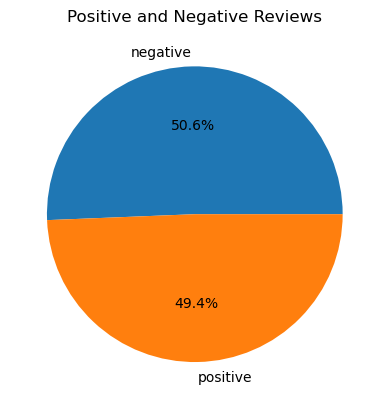

In [16]:

plt.pie(reviews_sentiment_count, labels = reviews_sentiment_count.index,autopct='%1.1f%%')
plt.title('Positive and Negative Reviews')
plt.ylabel('')
plt.show()


#### This shows positive and negative review are 50-50 %

## Step 2 : Text preprocessing

### 1.Removing html text using Beautifulsoup

- As there are various html tags in our review body text.so, removing it using beautiful soup

In [17]:
from bs4 import BeautifulSoup

data['review_body_text'] = data['review_body_text'].apply(
             lambda review_body_text: BeautifulSoup(review_body_text, "html.parser").get_text()
    )

C:\Users\nirma\AppData\Local\Temp\ipykernel_18060\994431550.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  lambda review_body_text: BeautifulSoup(review_body_text, "html.parser").get_text()


In [ ]:
ps = nltk.PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    # Lowercase and remove punctuation
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    
    tokens = re.split('\W+', text)# Tokenize
    
    # Remove stopwords and stem
    tokens = [ps.stem(word) for word in tokens if word and word not in stopwords]
    return tokens

data['tokenized_review_text'] = data['review_body_text'].apply(clean_text)

data.head()

<>:9: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\W'
C:\Users\nirma\AppData\Local\Temp\ipykernel_18060\3565403966.py:9: SyntaxWarning: invalid escape sequence '\W'
  tokens = re.split('\W+', text)


,review_body_text,sentiment,tokenized_review_text
0,One of the other reviewers has mentioned that ...,positive,"[one, review, mention, watch, 1, oz, episod, y..."
1,A wonderful little production. The filming tec...,positive,"[wonder, littl, product, film, techniqu, unass..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonder, way, spend, time, hot, summe..."
3,Basically there's a family where a little boy ...,negative,"[basic, there, famili, littl, boy, jake, think..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[petter, mattei, love, time, money, visual, st..."


## Vectorize

### Vectorizing the review using TF-IDF method

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer=clean_text)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['review_body_text'])

### Vectorizing the review using Word2Vec method

In [26]:


# Training w2vtor mode
w2v_model = gensim.models.Word2Vec(sentences=data['tokenized_review_text'], vector_size=100, window=5, min_count=2, workers=4)

def vectorize_review(review, model):
    vectors = [model.wv[word] for word in review if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

w2v_matrix = np.array(data['tokenized_review_text'].apply(lambda x: vectorize_review(x, w2v_model)))



In [ ]:
w2v_df = pd.DataFrame(w2v_matrix)
w2v_df.head()

,0
0,"[-0.2821796, 0.44669226, 0.026691653, 0.156820..."
1,"[-0.35355926, 0.5172762, 0.14557233, 0.1867738..."
2,"[-0.3100037, 0.4772943, 0.093355216, 0.2328411..."
3,"[-0.3416697, 0.45506012, 0.032255724, 0.221758..."
4,"[-0.32831398, 0.43352494, 0.05900041, 0.151835..."


### Step-4 : Exploratory Data Analytis and Feature engineering 

### 1. Review Length visualization

In [43]:
data['review_text_length'] = data['tokenized_review_text'].apply(lambda text:len(text) - text.count(" "))
positive_review_length = data[data['sentiment'] == 'positive']['review_text_length']
negative_review_length = data[data['sentiment'] == 'negative']['review_text_length']


#### a. Postive reviews length visualization

Text(0.5, 0, 'Positive Review Length')

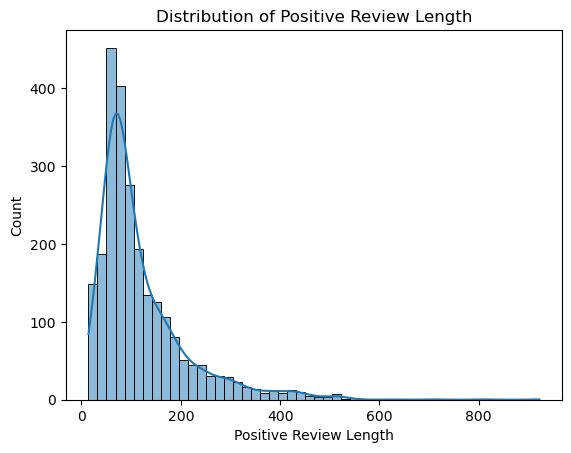

In [44]:
sns.histplot(data = positive_review_length, bins = 50, kde = True)
plt.title('Distribution of Positive Review Length')
plt.xlabel("Positive Review Length")

#### b. Negative reviews length visualization

Text(0.5, 0, 'Negative Review Length')

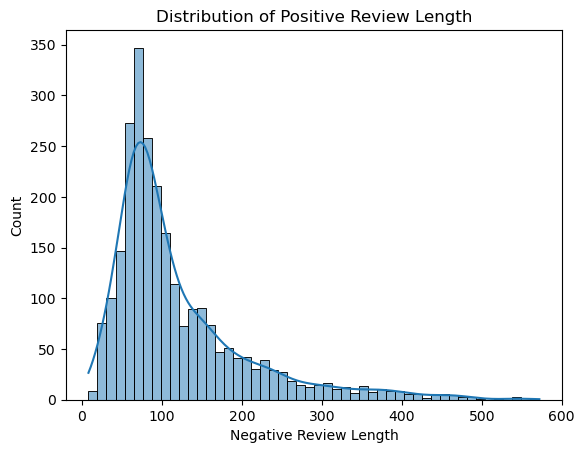

In [45]:
sns.histplot(data = negative_review_length, bins = 50, kde = True)
plt.title('Distribution of Positive Review Length')
plt.xlabel("Negative Review Length")

### 2. Punctuation percentage reviews 

In [46]:
def count_punct(text):
    punct_count = [char for char in text if char in string.punctuation]
    sum_of_punct = len(punct_count)
    return round(sum_of_punct/(len(text) - text.count(" ")), 3) * 100 

#Punct% should be done on the original text as cleaned text contains no punctuation
data['punct%'] = data['review_body_text'].apply(lambda text:count_punct(text))

positive_review_punct = data[data['sentiment'] == 'positive']['punct%']
negative_review_punct = data[data['sentiment'] == 'negative']['punct%']


Text(0.5, 0, 'Positive Punctuation % ')

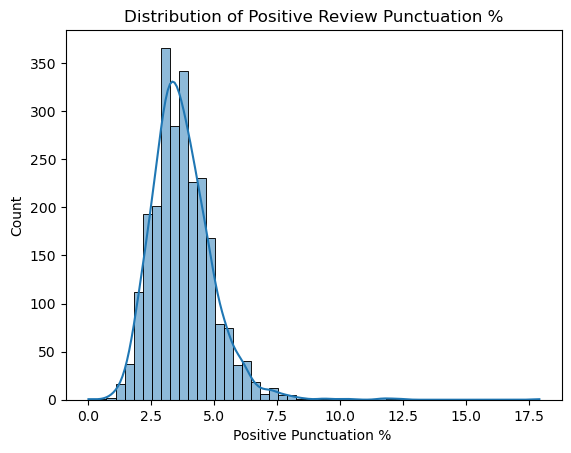

In [47]:
sns.histplot(data = positive_review_punct, bins = 50, kde = True)
plt.title('Distribution of Positive Review Punctuation %')
plt.xlabel("Positive Punctuation % ")

Text(0.5, 0, 'Negative Punctuation % ')

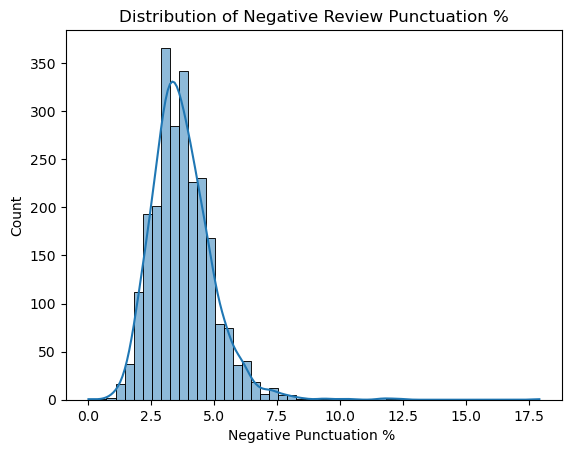

In [48]:
sns.histplot(data = positive_review_punct, bins = 50, kde = True)
plt.title('Distribution of Negative Review Punctuation %')
plt.xlabel("Negative Punctuation % ")

### Step 5: Sentiment Classification Model

#### Model Building Using Tf-IDF

#### Encode Target Variable

In [62]:
data['sentiment_encoded'] = data['sentiment'].map({'positive': 1, 'negative': 0})


#### Prepare TF-IDF Features and Target Variable

In [63]:
# Selecting features for TF-IDF approach
X_tfidf = data[['review_body_text', 'review_text_length', 'punct%']]
y = data['sentiment_encoded']  # Target variable


In [64]:
# Train-test split for TF-IDF features
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42)


#### TF-IDF Vectorization

In [191]:

tfidf_vect = TfidfVectorizer(analyzer=clean_text)

# Fitting oand transforming both train and test sets
X_train_tfidf_vect = tfidf_vect.fit_transform(X_train_tfidf['review_body_text'])
X_test_tfidf_vect = tfidf_vect.transform(X_test_tfidf['review_body_text'])


#### Combine TF-IDF Features with Other Features

In [216]:
X_train_tfidf_vect_combined = np.hstack([
    X_train_tfidf[['review_text_length', 'punct%']].values,
    X_train_tfidf_vect.toarray()
])
X_test_tfidf_vect_combined = np.hstack([
    X_test_tfidf[['review_text_length', 'punct%']].values,
    X_test_tfidf_vect.toarray()
])

In [218]:


# Train a Random Forest model using the combined features 
rf_tfidf_model = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)
rf_tfidf_model.fit(X_train_tfidf_vect_combined, y_train)
y_tfidf_pred = rf_tfidf_model.predict(X_test_tfidf_vect_combined)

#### Sentiment review prediction

In [219]:

# Now your prediction code will work as expected:
review_sample_text = "The movie was incredibly amazing and good."

review_length = len(clean_text(review_sample_text))
punct_percent = count_punct(review_sample_text)

tfidf_features = tfidf_vect.transform([review_sample_text])
combined_features = np.concatenate([[review_length, punct_percent], tfidf_features.toarray()[0]])

prediction = rf_tfidf_model.predict([combined_features])
print("Positive" if prediction[0] == 1 else "Negative")

Positive


In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

model_evaluation_results = {
    'Accuracy': [accuracy_score(y_test, y_pred)],
    'Precision': [precision_score(y_test, y_pred)],
    'Recall': [recall_score(y_test, y_pred)]
}

print(model_evaluation_results)

{'Accuracy': [0.832], 'Precision': [0.8355555555555556], 'Recall': [0.8]}


### Model Building Using Word2Vec

#### Prepare Word2Vec Feature Set

In [85]:
# Preparing a separate split for Word2Vec, which uses tokenized text
X_word2vec = data[['tokenized_review_text', 'review_text_length', 'punct%']]
X_train_word2vec, X_test_word2vec, y_train, y_test = train_test_split(
    X_word2vec, y, test_size=0.2, random_state=42)

In [ ]:

# Train using Word2Vec model
w2v_model = gensim.models.Word2Vec(X_train_word2vec,
                                   vector_size=100,
                                   window=5,
                                   min_count=1)




### Vectorizing for Word2Vec

In [ ]:
# vectorizing 
def vectorize_review(review, model):
    vectors = [model.wv[word] for word in review if word in model.wv]  
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

X_train_w2vt_vect = np.array(X_train_word2vec['tokenized_review_text'].apply(lambda x: vectorize_review(x, w2v_model)).tolist())
X_test_w2vt_vect = np.array(X_test_word2vec['tokenized_review_text'].apply(lambda x: vectorize_review(x, w2v_model)).tolist())


In [87]:
X_train_w2vt_vect

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Making random classifier model for word2vec

In [127]:
rf_w2v_model = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)
rf_w2v_model.fit(X_train_w2vt_vect, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [129]:
y_w2v_pred = rf_w2v_model.predict(X_test_w2vt_vect)


In [97]:
y_w2v_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Model evaluation for word2vec

In [98]:
w2v_model_evaluation_results = {
    'Accuracy': [accuracy_score(y_test, y_w2v_pred)],
    'Precision': [precision_score(y_test, y_w2v_pred)],
    'Recall': [recall_score(y_test, y_w2v_pred)]
}

print(w2v_model_evaluation_results)

{'Accuracy': [0.536], 'Precision': [0.6666666666666666], 'Recall': [0.02553191489361702]}


### Sentiment prediction using Using Word2Vec

In [220]:
# Correct way to predict with Word2Vec model
review_sample_text = "The movie was incredibly bad"
tokens = clean_text(review_sample_text)
w2v_features = vectorize_review(tokens, w2v_model)
prediction = rf_w2v_model.predict([w2v_features])

print("Positive" if prediction[0] == 1 else "Negative")

Negative
